# Solution of task 02

The following notebook contains solutions for the task 02.

First, we establish some code for printing graphs of measurements

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import Literal
import numpy as np

case_data =  {
    "Local": "01-local.csv",
    "Remote Searcher": "02-remoteSearcher.csv",
    "Remote Nodes": "03-remoteNodes.csv",
    "Both Remote": "04-bothRemote.csv",
    "Remote Searcher n=8": "05-remoteSearcher-n-equals-8.csv",
    # "Remote Nodes n=8": "05x-remoteNodes-n-equals-8.csv",
}

Case = Literal[* case_data.keys()]


def plot_graph(case_name, field="Time"):

    df = pd.read_csv(case_data[case_name])

    plt.figure(figsize=(12, 6))

    # Plot separate lines for each edge count
    for edge_count in sorted(df['Edges'].unique()):
        edge_data = df[df['Edges'] == edge_count]
        
        # Calculate mean time for each distance
        mean_times = edge_data.groupby('Distance')[field].mean()
        
        plt.plot(mean_times.index, 
                mean_times.values, 
                marker='o', 
                label=f'{edge_count:,} edges',
                linewidth=2,
                markersize=6)

    # plt.yscale('log')  # Set y-axis to logarithmic scale

    plt.title('Average Query Time vs Distance by Edge Count - ' + case_name)
    plt.xlabel('Distance')
    plt.ylabel(f"{field} (ms)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Add some padding to the axes
    plt.margins(x=0.05)
    # Set y-axis ticks every 1000 units
    y_min, y_max = plt.ylim()
    if y_max < 100_000:
        plt.yticks(np.arange(0, y_max + 1000, 1000))  # Adjust step if needed

    plt.show()
    



## 1. Local measurement

> **Measure** the speed of execution on several randomly generated graphs of different sizes (this is just the first of 5 variants).


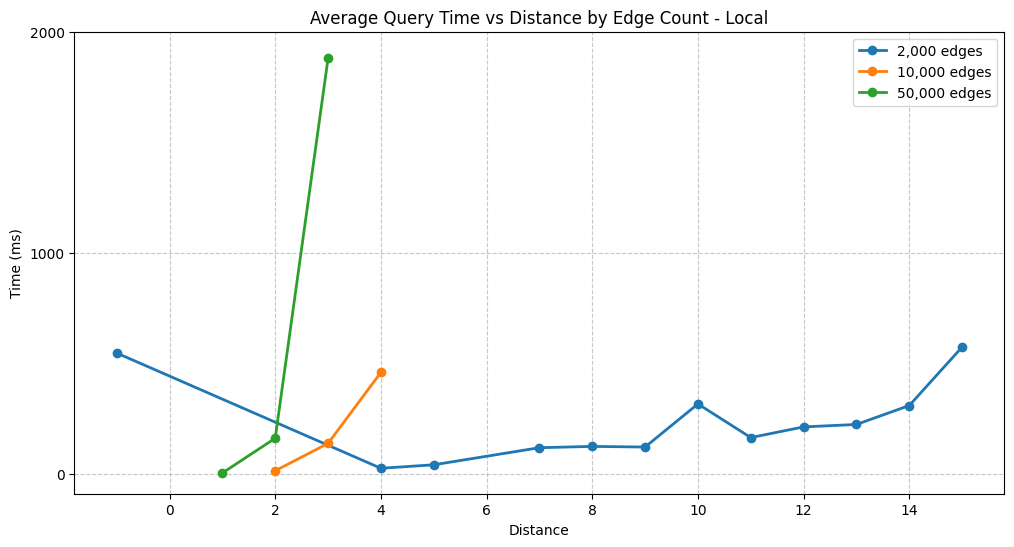

In [3]:

plot_graph("Local")


Interpretation: Somewhat naturally, the denser the graph, the slower the search.

Steps to replicate:
```sh
mvn -q compile exec:java@run-client "-Dexec.args=cz.cuni.mff.d3s.nswi080.testsuite.suites.LocalTestSuite" >01-local.csv
```

## 2\. Remote Searcher

**Measure** the speed of the implemented variants and show how the times depend on the distance and density (number of edges).

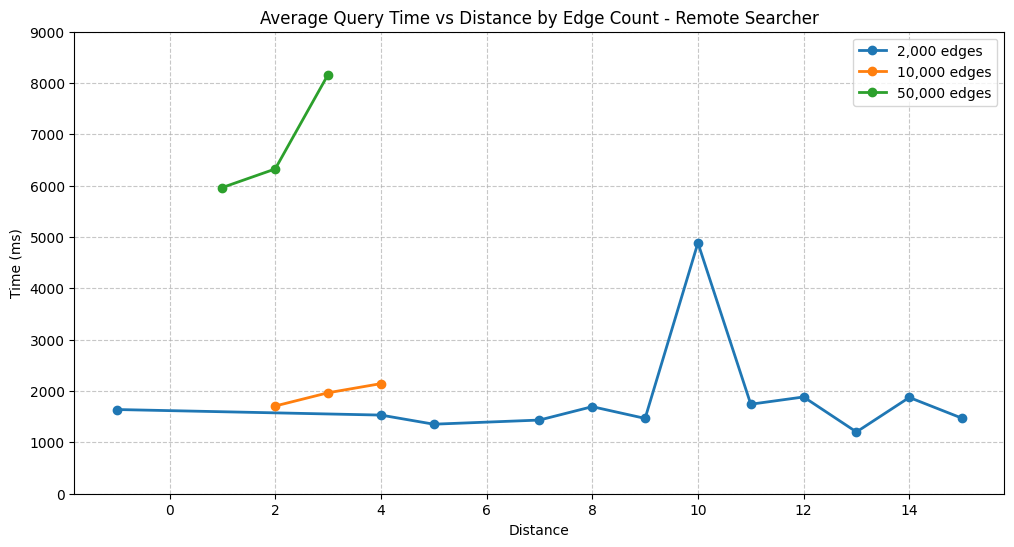

In [4]:
plot_graph("Remote Searcher")

Interpretation: trends are similar, however it is much slower now, introducing the overhead of RMI server communication.

> **Question:** How does the server `Searcher` object access the `Node` objects and the set of their successors? What parts of RMI are involved in this process?

The objects are serialized, passed "by value", ie. "by copy". The Node was extended to implement Seriazable and is sent serialized.

Steps to replicate:
```sh
mvn compile exec:exec@run-server "-DargLine=-Xss128m"
mvn -q compile exec:java@run-client "-Dexec.args=cz.cuni.mff.d3s.nswi080.testsuite.suites.RemoteSearcherSuite"
```



## 3\. Remote Nodes

> **Measure** the speed again and show how the times depend on the distance and density.


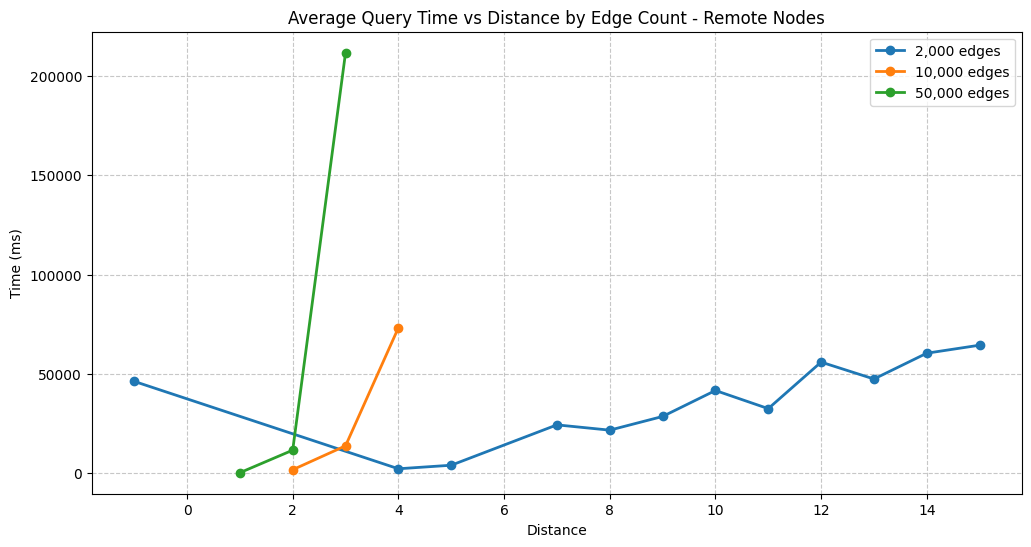

In [5]:
plot_graph("Remote Nodes")


Interpretation: The graph seems to follow the same pattern as local because but the RMI overhead is much larger. This must be caused by the larger amount of remote calls caused by the fact that a remote call is made for every node fetched.

> **Question:** How does the local `Searcher` object access the server `Node` objects? What exactly does the `NodeFactory` return to the client from `createNode`? What parts of RMI are involved in this process?

The `NodeFactory` exports the Node objects on creation, so they are not sent serialized, rather their methods are invoked remotely through the RMI protocol. Even though the Searcher implementation is local, every time it calls a method on a Node object (like getDirectSuccessors() or getTransitiveSuccessors())

The NodeFactory, which itself is a stub which invokes the method remotely, returns stubs for remote nodes.

> What parts of RMI are involved in this process?

- Remote interface (Node)
  The Node interface must extend java.rmi.Remote, and all its methods must declare throws RemoteException.
- Remote object (on the server)
  The server must provide an implementation of Node that is exported as a remote object using:
  Extending UnicastRemoteObject, or Using UnicastRemoteObject.exportObject().
- Stub generation and proxying
  RMI generates dynamic stubs that the client receives. These stubs are serialized references to the actual remote objects and forward method calls over the network.
- RMI Registry and lookup
  The client retrieves a reference to NodeFactory via the RMI registry using Naming.lookup(), then uses it to get Node stubs.
- Remote method invocation flow
  Every call from the local Searcher to the remote Node is a networked RMI call:
  Method call → stub → RMI transport → server object → result → back to client.


Steps to replicate:
```sh
mvn compile exec:exec@run-server "-DargLine=-Xss128m"
mvn -q compile exec:java@run-client "-Dexec.args=cz.cuni.mff.d3s.nswi080.testsuite.suites.RemoteNodesSuite"
```

## 4\. Remote Nodes and Searcher

**Measure** the speed again and show how the times depend on the distance and density.

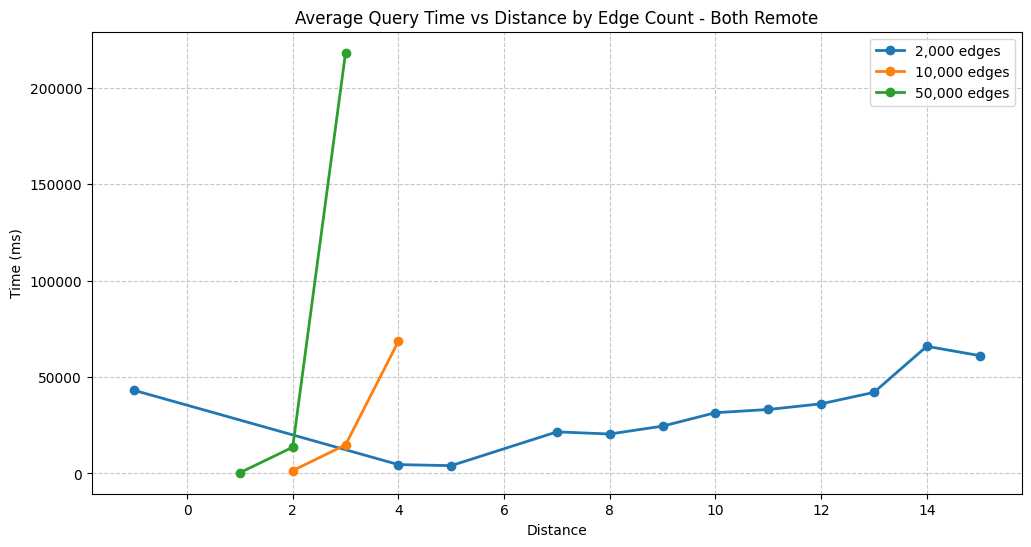

In [6]:
plot_graph("Both Remote")


**Question:** How does the server `Searcher` access the server `Node` objects (on the same server)? What parts of RMI are involved in this process?

In this configuration, both the Searcher and the Node objects are hosted on the same server. 
When the client passes references to these Node objects back to the server-side Searcher, those references are still remote stubs, even though they point to objects that are already local.
When the Searcher calls methods on the Node objects, it's still calling RMI methods on local objects. Thanks to the way RMI works, these calls are optimized as local calls, avoiding network overhead — loopback.

Added to previously mentioned, the RMI Loopback Optimization is also utilized: RMI recognizes when a remote stub refers to an object already in the current JVM. It bypasses networking and performs an optimized local call to the actual object.

Steps to replicate:
```sh
mvn compile exec:exec@run-server "-DargLine=-Xss128m"
mvn -q compile exec:java@run-client "-Dexec.args=cz.cuni.mff.d3s.nswi080.testsuite.suites.RemoteBothSuite" >04-both-remote.csv
```


## 5\. Passing by Value vs. Passing by Reference

> **Question:** In which one of the four variants (both local, remote searcher, remote nodes, both remote) does this parameter have a significant effect on network traffic?

The larger the n, the less calls, but the larger the amount of nodes returned. In both remote searcher and remote nodes, the nodes are sent, be it as stubs or serialized. So the network traffic is affected there. In the case with both remote, the loopback is involved, which means network trafic should be not affected except for loopback traffic.

> **Question:** How does the parameter affect the amount of data passed through the network during the execution of the algorithm? Compare it with the previous variants.

The larger the n, the less remote calls, but the larger the amount of nodes returned.

> **Measure** this new variant -- choose the best local/remote configuration and a reasonable value of _n_, which you expect to perform differently from the previous variants.

Reproduce: 
```sh
mvn -q compile exec:java@run-client "-Dexec.args=cz.cuni.mff.d3s.nswi080.testsuite.suites.RemoteSearcherSuite 1000 2000,10000,50000 //localhost:1099 8" >.\05-remoteSearcher-n-equals-8.csv
```

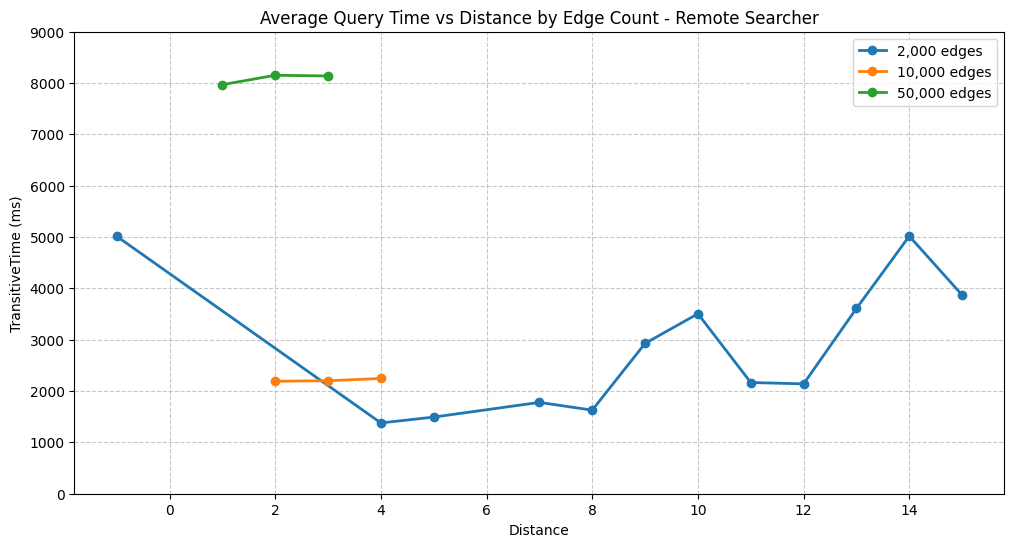

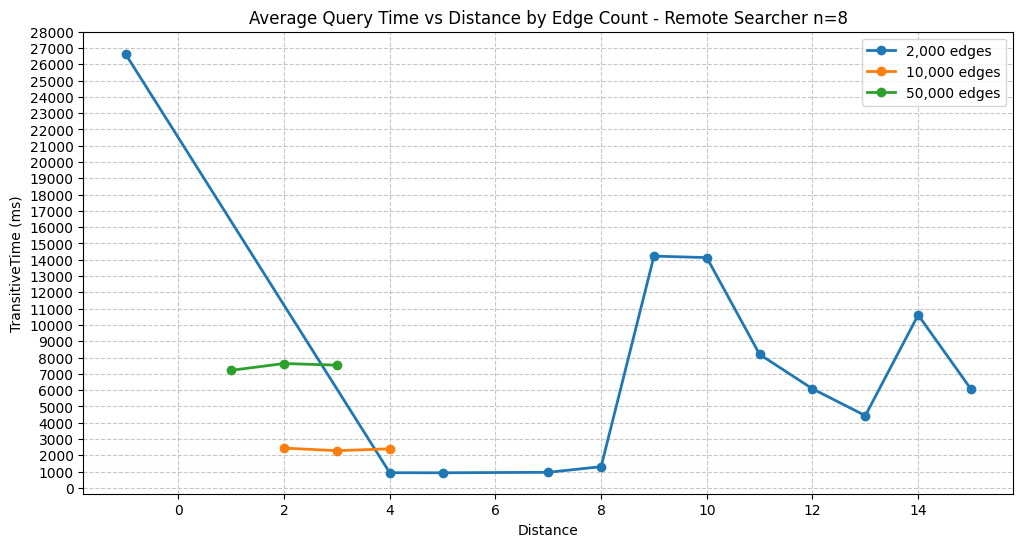

In [7]:
plot_graph("Remote Searcher", "TransitiveTime")
plot_graph("Remote Searcher n=8", "TransitiveTime")

Interpretation: We see no change for the better for the cases where distance is below 8, as expected, except for the time being worse. Especially the time for not found paths in not dense graph - because the number of nodes that will be transferred will be signifivantly larger.

Mostly we are worse of, but for the case for distances 4-8, the time has improved by ca 500 ms. For distance 9, where we could expect an improvement of less calls, we see the affect of larger amount of nodes returned, where we are actually worse of.

## 6\. Network Impact

**Compare** the speed of the five variants when both client and server are running on the same machine. Measure everything in one run to ease comparison. Plot the results into a chart with five data series corresponding to the five variants.


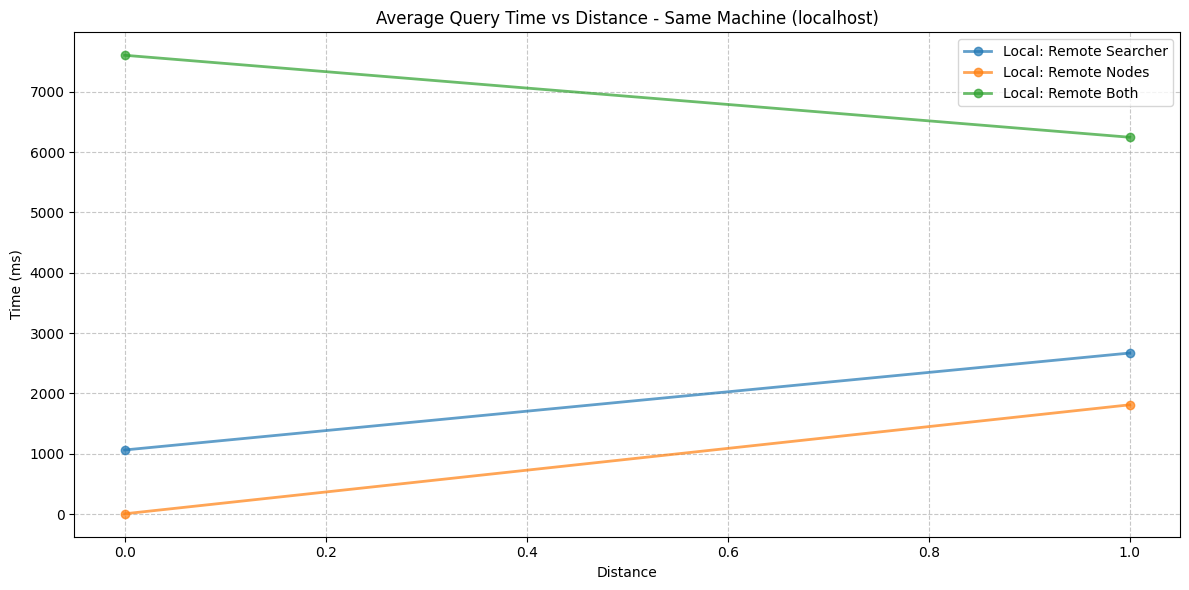

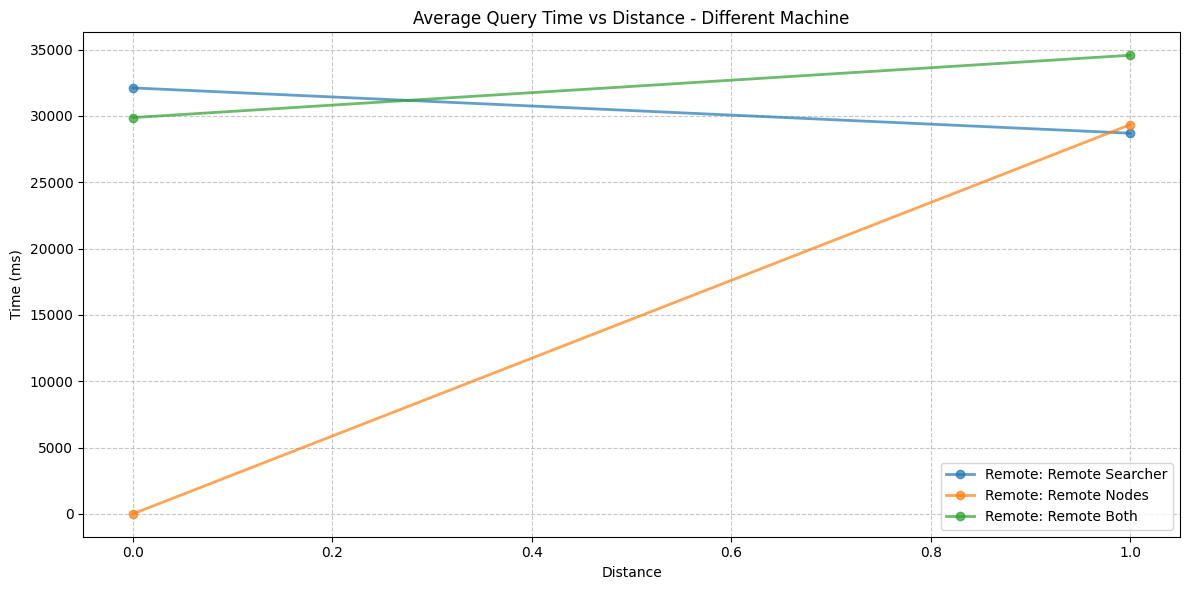

In [12]:
def plot_all_variants_comparison(case_data, edge_filter=1000, title_suffix="(Same Machine)"):

    plt.figure(figsize=(12, 6))



    for case_name, filename, field in case_data:
        df = pd.read_csv(filename)

        # Filter to only one edge density for consistent comparison
        df = df[df['Edges'] == edge_filter]

        # Calculate average time for each distance
        mean_times = df.groupby('Distance')[field].mean()

        plt.plot(mean_times.index, 
                 mean_times.values,
                 marker='o', 
                 label=case_name,
                 linewidth=2,
                 markersize=6,
                 alpha=0.7)  # Adding transparency (alpha)

    plt.title(f"Average Query Time vs Distance - {title_suffix}")
    plt.xlabel('Distance')
    plt.ylabel(f'{field} (ms)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.margins(x=0.05)


    plt.tight_layout()
    plt.show()

case_data_local =  [
("Local: Remote Searcher", "06-local-remoteSearcher.csv", "Time"),
("Local: Remote Nodes", "06-local-remoteNodes.csv", "Time"),
("Local: Remote Both", "06-local-remoteBoth.csv", "Time"),
]

case_data_remote =  [
("Remote: Remote Searcher", "06-remote-remoteSearcher.csv", "Time"),
("Remote: Remote Nodes", "06-remote-remoteNodes.csv", "Time"),
("Remote: Remote Both", "06-remote-remoteBoth.csv", "Time")
]


plot_all_variants_comparison(case_data_local, title_suffix="Same Machine (localhost)")

plot_all_variants_comparison(case_data_remote, title_suffix="Different Machine")

Steps to replicate:
```sh
# for each:
mvn -q compile exec:java@run-client -Dexec.args="cz.cuni.mff.d3s.nswi080.testsuite.suites.BothRemoteSuite 10 100,200,1000 //198.7.113.88:1099
```

**Explain** the cause of the differences in the times, based on the role of RMI in each variant.

Remote nodes and both remote - the time is proportional to the number of remote stubs needed. The remote searcher does not have remote nodes, instead gets them serialized, which lessens the overhead.

Do the same for a situation when the client and server are on different physical computers connected by a network. Test in a higher latency environment, e.g., between your computer and a computer in the school lab.

Note: I used 10 nodes and 1000 edges, because otherwise the evaluation was too slow and didnt finish for RemoteNodes case. This does not seem like a good scenario, but I wanted to have at least something.

**Compare** the results of the two situations.

Remote Searcher: Fastest 
   - only one RMI call per search operation
   - nodes are serialized and sent once
   - network overhead is minimal due to low latency

Remote Nodes - Slowest 
   - every node operation requires a separate RMI call
   - multiple network trips during graph traverse
   - every getDirectSuccessors call is a remote operation

Both Remote - slightly better than Remote Nodes because
   - remote searcher can optimize some operations server-side
   - still has multiple remote calls for node operations
   - network overhead is significant but less than Remote Nodes

Two machines - High Latency 

Remote Searcher 
   - Single RMI call means only one latency penalty
   - Larger serialization overhead due to sending entire graph
   - Latency impact is predictable and constant

Remote Nodes -  Performance degrades dramatically because:
   - Each remote call now includes high latency
   - Multiple sequential remote calls multiply the latency impact
   - Graph traversal becomes extremely slow due to accumulated latency

Both Remote - Similar degradation to Remote Nodes because:
   - Still requires multiple remote calls for node operations
   - High latency affects each node operation
   - Some benefit from server-side optimization is lost to network latency

**Explain** the cause of the differences in the times, based on the role of RMI in each variant.

The key factors affecting performance are:
Number of Remote Calls: RemoteSearcher: O(1) remote calls per search, Remote Nodes: O(N) remote calls where N is the number of nodes visited, both Remote: O(N) remote calls but with some server-side optimization

Data Transfer Volume: Remote Searcher: Large one-time transfer of serialized graph. Remote Nodes: Small transfers but many of them. Both Remote: Similar to Remote Nodes

Latency Impact: Remote Searcher: Latency affects only once per search. Remote Nodes: Latency compounds with each node operation. Both Remote: Similar to Remote Nodes but with slight optimization

The performance degradation in high latency scenarios is most severe for implementations that require multiple remote calls (Remote Nodes and Both Remote) because each call must wait for the full round-trip time. This is why you observed that the Remote Nodes case became particularly slow and potentially unfinishable with larger graphs - the cumulative latency of all the required remote calls made the operation impractical.

